# GPU-Accelerated Machine Learning with RAPIDS


### CSCS-USI Summer School 

<br>
<br>
#### Young-Jun Ko (NVIDIA)

22.07.2019


# About me

- Young-Jun ($\approx$ Young - "not old" Jun - "month of June")
- Past:
    - SW Developer (IBM, SAP)
    - Saarland Uni, EPFL
    - ML Engineer at "big data" startup 
- Since Nov 2018:
    - AI DevTech Engineer at NVIDIA, based in Zurich
        - Looked into HPC+AI 
        - Contributed algorithms to RAPIDS `cuml` library 
        - Recently: NNs for NLP
- About you?

# Thanks to the Organizers


# Outline

- RAPIDS - "Yet Another ML lib"?
- Recap of ML Fundamentals
- Opening the black box: ML algorithm deep dive
- Hands-on

# ML and Libraries at NVIDIA

<center>
 <img src="nvidia_dl.png" style="width: 500px;"/>  
 
 <img src="dl_frameworks.png" style="width: 200px;"/> 




# Datascience Workloads - But not only Deep Learning

<br>
<center>
 <img src="datascience.png" style="width: 800px;"/>  

# Datascience Workloads - But not only Deep Learning

<br>
<center>
 <img src="datascience_stages.png" style="width: 800px;"/> 


# Python - A Datascientist's Favorite

<br>
<center>
 <img src="pystack.png" style="width: 600px;"/> 


# RAPIDS according to RAPIDS: [rapids.ai](http://rapids.ai)

<br>
<center>
 <img src="rapids.png" style="width: 600px;"/> 
    
 <img src="rapids_p.png" style="width: 300px;"/> 


# A Taste of RAPIDS


| Pandas/Scikit-learn                                        |                                     RAPDS cuDF/cuML |
|-----------------------------------------------|-------------------------------------------------|
|<img src="rapids_comp_pandas.png" style="width: 450px;"/>  | <img src="rapids_comp_cudf.png" style="width: 450px;"/> |
|<img src="rapids_comp_scikit.png" style="width: 450px;"/>  | <img src="rapids_comp_cuml.png" style="width: 450px;"/> |


# Summary

- Datascience has become an important work load in many areas
- "Classic", i.e. non-DL methods, still very much alive and well
- GPU-Acceleration of non-DL ML methods lagging behind
    - But: data procesing time increasing everywhere (end of Moore's law, "data deluge")!
    - Virtuous cycle: faster results -> more experiments -> better results -> better exeriments
    - Optimize for most valuable resource: scientists'/engineers', i.e. your, time!
- RAPIDS: open-source, integrating into the python eco-system
    - New, ambitious project
    - `cuDF`: columnar data storage and manipulation, like pandas
    - `cuML`: toolbox of ML algorithms, like scikit-learn
    - `cuGraph`: toolbox of graph mining algorithms
    - `DASK` integration for distributed dataframes and algorithms
    - Goal: seamless, "drop-in" replacement

# Outline

- RAPIDS - "Yet Another ML lib"?
- Recap of ML Fundamentals
- Opening the black box: ML algorithm deep dive
- Hands-on

# Recap of ML Fundamentals

- Disclaimer: mild notational abuse and a lot of hand-waving ahead!
- Conceptual intuition > mathematical rigour

# Checklist of Concepts

- Supervised learning 
- Families of functions as models, learning algorithms, and loss functions
- Generalization, risk, and the bias-variance tradeoff


# Supervised Learning

- The most common/successful paradigm
- The setup:
    - Input/feature space: $\mathcal{X}$, e.g. $\mathbb{R}^d$
    - Output/target space: $\mathcal{Y}$, e.g. $\mathbb{R}$ (regression), $\{\pm1\}$ (classification)
- Hidden relationship: $P(X, Y)$
    - Probabilistic perspective useful for acknowledging noise
    - $P$ is unknown (but we'll encounter it again in a moment)
    - But, we have access to $N$ i.i.d. samples $(x_i , y_i) \sim P(X, Y)$
- Goal:
    - find a "good" predictor $f : \mathcal{X} \mapsto \mathcal{Y}$


# Example: Regression in 1D

- $\mathcal{X} = \mathbb{R}$
- $\mathcal{Y} = \mathbb{R}$
- find $f: \mathbb{R} \mapsto \mathbb{R}$, to make queries like "What is $f(0.4)$?"

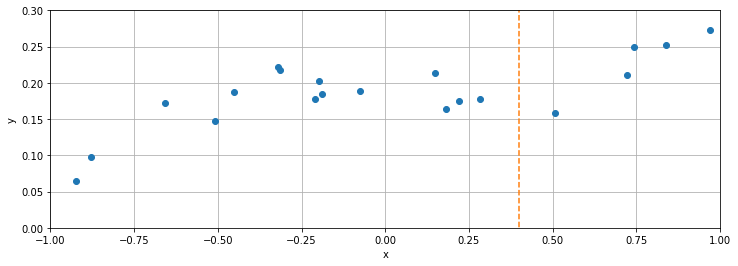

In [16]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(123456)
def f_true(x):
    return 0.1 * x**3 - 0.025 * x **2 + 0.01 *x + 0.2 

N = 20 

n = np.random.randn(N,1) * 0.025
x = 2 * np.random.rand(N,1) - 1
y = np.array([f_true(_x) for _x in x]) + n

n2 = np.random.randn(N,1) * 0.025
x2 = 2 * np.random.rand(N,1) - 1
y2 = np.array([f_true(_x) for _x in x]) + n

plt.figure(figsize=(12,4))
plt.plot(x,y, 'o')
plt.grid(True)
plt.xlim([-1,1])
plt.ylim([0, 0.3])
plt.xlabel('x')
plt.ylabel('y')
plt.plot([0.4,0.4], [-1,1],'--')

xtest = np.linspace(-1, 1, 500).reshape(500, 1)

# Checklist of Concepts

- Supervised learning: $\mathcal{X}, \mathcal{Y}, P(X,Y), f$
- Families of functions as models, learning algorithms, and loss functions
- Generalization, risk, and the bias-variance tradeoff


# Models, Learning Algorithms and Loss Functions

- We choose a family of functions $\mathcal{F}$ from which we choose the predictor: $f \in \mathcal{F}$
- Here, we assume that $f$ is parameterized by a set of parameters $\theta$, which we can use to index elements in $\mathcal{F}$
- I.e. we can identify $f_{\theta} \in \mathcal{F} $ by their parameters $\theta$
- A learning algorithm would then be a function that takes a sample and returns a set of parameters:
$$\mathcal{A}_{\mathcal{F}}( \{(x_i, y_i)\}) = \hat \theta$$
- It "fits the model to the data", which implies a way of quantifying "good" and "bad" (but there might be multiple notions involved!)
- Loss function: $$l: \mathcal{Y} \times \mathcal{Y} \mapsto \mathbb{R}$$
    - Compares a true $y \in \mathcal{Y}$ to a predicted $\hat y = f(x)$
    - Encodes the cost we assign to errors
    - Examples:
        - squared loss: outliers cost a lot - avoid
        $$ l(y, \hat y) = (y - \hat y)^2$$
        - absolute-error: outliers cost less - tolerate 
        $$ l(y, \hat y) = |y - \hat y|$$

# Example: The family of order-k polynomials

- Functions of this form: $ f_{\theta}(x) = \sum_{i=0}^{k} w_i x^i $
- Parameters $\theta = \{w_0, \ldots, w_k\}$
- Family $\mathcal{F} = \{ f_{\theta} \}$
- Learning algorithm and loss: e.g. least-squares regression when using squared error
\begin{aligned}
\min_{\theta} \frac{1}{2}\Vert y - f_{\theta}(x) \Vert^2 = \min_{\theta} \frac{1}{2} \Vert y - \Phi(x) w \Vert^2  \qquad
\mathcal{A}_{\mathcal{F}}(x, y) = (\Phi^T \Phi)^{-1} \Phi^T y
\end{aligned}

- Side note: linear in the parameters $\theta$, but non-linear feature transform $\phi_i(x) = x^i$
    - Neural networks can be thought of as making the feature map trainable!

- In code:

```python
def phi(x, order):
    Phi = np.concatenate([x ** k  for k in range(order+1) ], axis=1 )
    return Phi

def lsq(X, y):
    A = np.dot(X.T, X)
    b = np.dot(X.T, y)
    return np.linalg.solve(A,b)
```

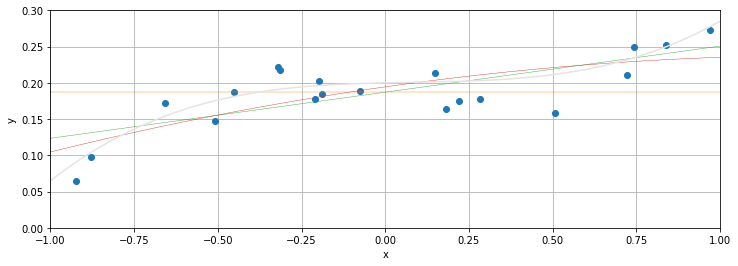

In [17]:
def phi(x, order):
    Phi = np.concatenate([x ** k  for k in range(order+1) ], axis=1 )
    return Phi

def lsq(X, y):
    A = np.dot(X.T, X)
    b = np.dot(X.T, y)
    return np.linalg.solve(A,b)

def poly_plot(x,y, k, xtest):
    Phi = phi(x, k)
    what = lsq(Phi, y)
    
    plt.figure(figsize=(12,4))
    plt.ion()
    plt.plot(x,y, 'o')

    Phi_test = phi(xtest, k)
    ypred = np.dot(Phi_test, what)
    plt.plot(xtest, ypred, '-')#, linewidth=0.8)
    ytrue = f_true(xtest)
    plt.plot(xtest, ytrue, '-', color='444444')
        
    plt.title("Fitting a polynomial of order k={}".format(k))
    plt.xlim([-1,1]); plt.ylim([0, 0.3])
    plt.xlabel('x'); plt.ylabel('y')
    plt.grid(True)


plt.figure(figsize=(12,4))
plt.plot(x,y, 'o')
k = 2
K = 3
for k in range(K):
    Phi = phi(x, k)
    what = lsq(Phi, y)

    Phi_test = phi(xtest, k)
    ypred = np.dot(Phi_test, what)

    plt.plot(xtest, ypred, '-', linewidth=0.4)
    

ytrue = f_true(xtest)
plt.plot(xtest, ytrue, '-', color='444444')
plt.xlim([-1,1])
plt.ylim([0, 0.3])
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)


# Example of fitted Model

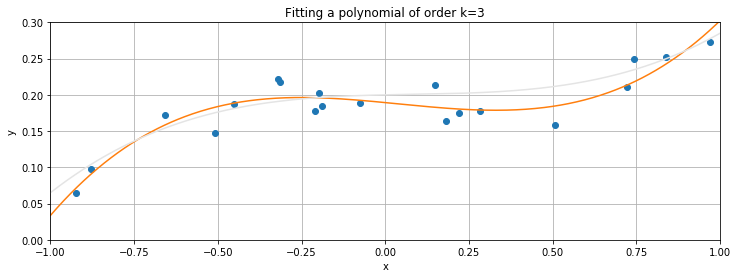

In [18]:
k =3 
poly_plot(x,y, k, xtest=xtest)
#poly_plot(x2,y2, k, xtest=xtest)

# Checklist of Concepts

- Supervised learning: $\mathcal{X}, \mathcal{Y}, P(X,Y), f$
- Families of functions as models, learning algorithms and loss functions: $f_{\theta} \in \mathcal{F}, \mathcal{A}_{\mathcal{F}}$ , $l(y, \hat y)$
- Generalization, risk, and the bias-variance tradeoff


# The True Risk

- If we knew $P$ (and could deal with it), for any predictor, we would want to compute the expected loss on the whole population to understand generalization
$$ R(f) := \mathbb{E}_P [ l(Y, f(X)) ] $$
- The risk is the ideal objective
$$ f^* = \arg\min_{f} R(f) \qquad\text{or at least} \qquad  f_{\mathcal{F}}^{*} := \arg\min_{f\in \mathcal{F}} R(f) $$
- Unfortunately, we can only _approximate_ $R$ statistically using our sample, i.e. calculate the _emprirical_ risk
$$\hat R(f) := \frac{1}{N} \sum_{i=1}^{N} l(y_i, f(x_i))$$
- And in practice, _empirical risk minimization_:
$$ f_N := \arg \min_{f \in \mathcal{F}} \hat R(f)$$
- We have:
$$ R(f^*) < R(f^*_{\mathcal{F}}) < R(f_N) \quad \text{but: } \hat R(f_N) < R(f_N) $$


# Empirical Risk and Generalization

- More importantly, $R(f_N)$ and $\hat R(f_N)$ can be completely independent of each other
    - $\hat R$ is _not_ a useful estimate of the generalization of $f_N$ (could be 0!)
    - We "used up" the sample for fitting the model
- I.e. the empirical risk will not tell us anything about the generalization error (the error on the whole population)
- However, generalization is all we care about
- Need another dedicated test sample, to estimate $R(f_N)$!
    - Check if fitting the model captured something useful or mostly noise


# Decomposing the Error

- Studying these quantities can give us some insights into what we can do about this
- We can compare our estimate $f_N$ with the best possible predictor $f^*$, and consider the (positive) risk difference:
$$ \mathbb{E} [R(f_N) -  R(f^*)]$$
- The expectation is taken over the samples ($f_N$ is a random quantity, if we don't condition on the training data)

\begin{aligned}
 \mathbb{E} [R(f_N) -  R(f^*)] &= \mathbb{E} [R(f_N) -  R(f^*) + R(f^*_{\mathcal{F}}) - R(f^*_{\mathcal{F}})] \\
 &= \mathbb{E} [ R(f^*_{\mathcal{F}})-  R(f^*) + R(f_N)  - R(f^*_{\mathcal{F}})]  \\
 &=  (R(f^*_{\mathcal{F}})-  R(f^*)) + (\mathbb{E} [ R(f_N) ]  - R(f^*_{\mathcal{F}})) \\
 &=  \text{Approximation Error} + \text{Estimation Error} \\
 &\rightarrow  \text{"Bias"} + \text{"Variance"} 
\end{aligned}

- The main object, we have control over: $\mathcal{F}$ 
    - allow less functions explicitely (e.g. restrict $k$)
    - add regularization that penalizes complexity
- Very "small" $\mathcal{F}$, i.e. low model complexity: high bias, low variance - we underfit
- Very "large" $\mathcal{F}$, i.e. high model complexity: low bias, high variance - we overfit


#### Extreme Underfitting: High Bias - Low Variance 

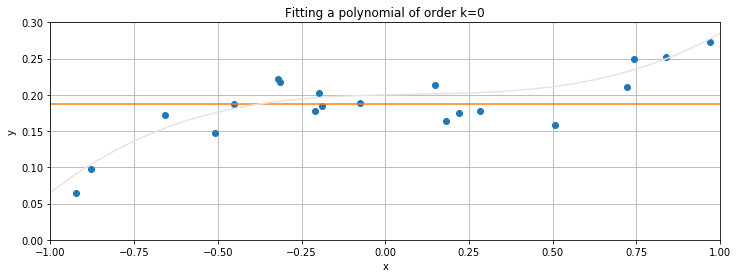

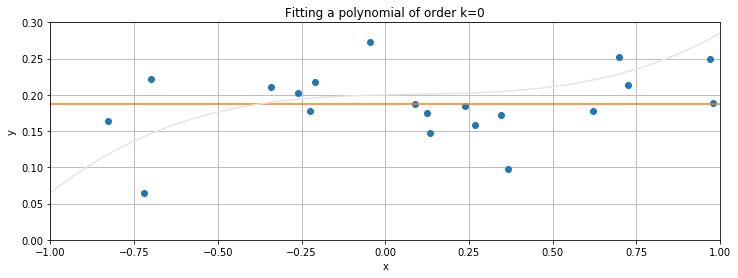

In [19]:
k =0 
poly_plot(x,y, k, xtest=xtest)
poly_plot(x2,y2, k, xtest=xtest)

#### Extreme Overfitting: Low Bias but Arbitrarily High Error

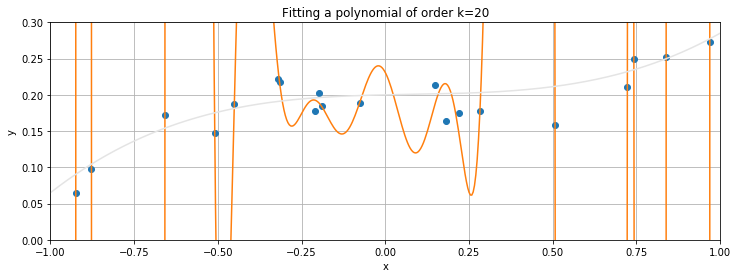

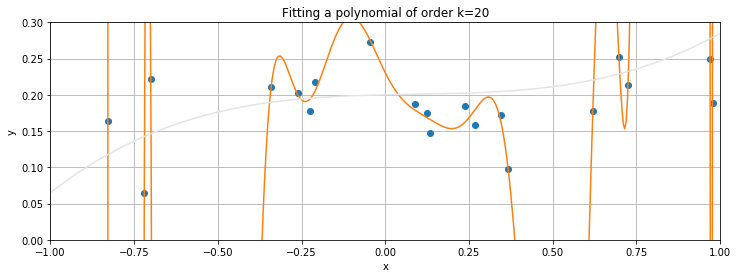

In [20]:
k =20 
poly_plot(x,y, k, xtest=xtest)
poly_plot(x2,y2, k, xtest=xtest)

#### Correct Order

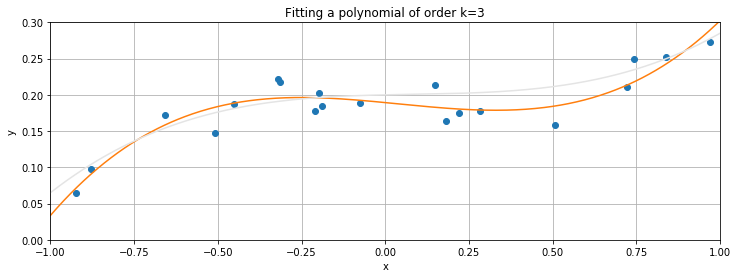

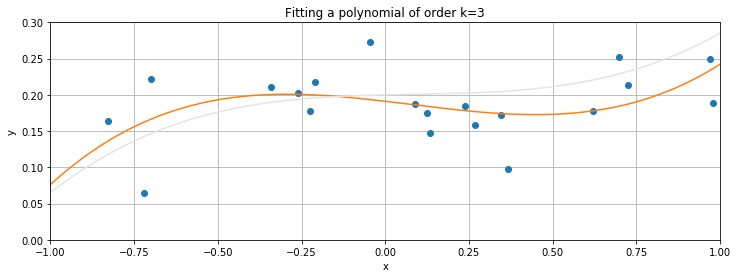

In [21]:
k =3 
poly_plot(x,y, k, xtest=xtest)
poly_plot(x2,y2, k, xtest=xtest)

# Checklist of Concepts

- Supervised learning: $\mathcal{X}, \mathcal{Y}, P(X,Y), f$
- Families of functions as models, and learning algorithms: $f_{\theta} \in \mathcal{F}, \mathcal{A}_{\mathcal{F}}$, $l$
- Generalization, risk, and the bias-variance tradeoff: $R$, over-/under-fitting


# Summary

- What Machine Learning is all about:
    - Choose an appropriate model (e.g. add regularization)
    - Come up with an efficient learning algorithm
    - Measuring Generalization is itself difficult: often estimates are optimistic (e.g. cross validation)
- Pracitical ML is by necessity very experimental (we don't have control over some key objects)
- Need tools:
    - Wide selection of models: software matters
    - It's a computational discipline: performance matters

# Outline

- RAPIDS - "Yet Another ML lib"?
- Recap of ML Fundamentals
- Opening the black box: ML algorithm deep dive
- Hands-on

# Opening the Black Box: ML Algorithm Deep Dive

1. Warm-up: Logistic Regression - A Generalized Linear Model
2. Decision Trees and XGBoost

# Logistic Regression - A Generalized Linear Model

- Linear models have been in the toolbox of statisticians for ages
- We've seen linear models for regression
- What about classification, i.e. $\mathcal{Y} = \{\pm 1\}$?
    - we could assume $\mathcal{Y}$ is just $\mathbb{R}$ and fit to the discrete labels. Better way?
- A probabilistic perspective: generative models and maximum likelihood estimation


# GLM Perspective on Least-Squares

- Consider modeling the mean $\mu$ of a standard normal with the linear function $\mu = f_{\theta}(x)$:
$$ P(Y \mid X=x) = N(Y \mid \mu(x), 1) \propto \exp(-\frac{1}{2} ( Y - \mu(x) )^2)$$
- The likelihood of the data is the probability of the dataset (conditioned on the parameters):
$$ P(Y=y \mid X=x, \theta) = \prod_{i=1}^N P(Y=y_i \mid X  = x_i, \theta)$$
- Maximizing the likelihood is equvalent to minimizing the negative log-likelihood:

\begin{aligned}
 -\log P(Y=y \mid X=x, \theta) &= - \sum_{i=1}^N \log P(Y=y_i \mid X  = x_i, \theta) \\
 &=  \sum_{i=1}^N \frac{1}{2} ( y_i - \mu(x_i) )^2 \\
 &=   \frac{1}{2} \Vert  y - f_\theta (x) \Vert^2 
\end{aligned}

- The likelihood uses the distribution conditioned on the parameters, but views it as a function of the condition. The data is fixed to the observations


# Logistic Regression

- no-one prevents us to model other distributions/data types for y, just need to find the right distribution and parameterization in terms of the predictor
- Now consider a binary RV $Y \in \{0, 1\}$
- Bernoulli distribution: $P(Y = 1 \mid p) = p$ $P(Y = 0 \mid p) = 1 - p$, can be written as:
$$P(Y = y) = p^y (1-p)^{1-y} $$
- The parameter $p \in [0,1]$ and $\mathbb{E}[Y ] = p$
- In logistic regression, we model the mean of $Y$ as $\mu(x) = p(x) = \sigma( f_{\theta}(x))$ 
- Logistc sigmoid $\sigma: \mathbb{R} \mapsto [0,1]$ for a valid probability, with $ \sigma(x) = {1}/(1+ \exp(-x)) $
- Interpretation:
    - Large positive values: we're sure about $Y = 1$
    - Small negative values: we're sure about $Y = 0$
    - Zero: uncertain about the outcome


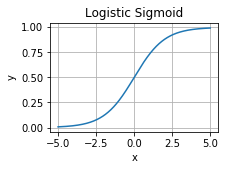

In [22]:
import scipy
from scipy.special import expit
blub =  np.linspace(-5, 5, 1000)
plt.figure(figsize=(3,2))
plt.plot(blub, [expit(_x) for _x in blub]);
plt.title("Logistic Sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Logistic Regresion: Likelihood

- Bernoulli distribution: 
$P(Y = y) = p^y (1-p)^{1-y} $ and $p(x) = \sigma( f_{\theta}(x))$
- Neg.log-likelihood:

\begin{aligned}
- \log P(Y=y \mid X=x, \theta) &= -\log \prod_{i = 1}^N \sigma(f_\theta(x_i))^{y_i} (1 - \sigma(f_\theta(x_i)))^{1 - y_i} \\
&= - \sum_{i = 1}^N y_i \log \sigma(f_\theta(x_i)) + (1 - y_i) \log (1 - \sigma(f_\theta(x_i)))  \\
&= \sum_{i = 1}^N l_\sigma (y_i,f_\theta(x_i))
\end{aligned}

- Simplifies a lot when expressed in $Y = \pm 1$
- Key point: $l_\sigma$ differentiable, we have $ \frac{\partial} {\partial f} l_\sigma(y,f)$ and even $\frac{\partial^2}{\partial f^2} l_\sigma (y, f) $

# Logistic Regression: Learning Algorithms

- No closed form solution. Iterative, gradient based optimization needed
- For most regularizers a convex problem, well behaved, well studied (can be important in practice/production!)
- Vast literature (primal/primal-dual/dual, stochastic/batch, ...)
- Key ingredient: $\nabla_\theta \sum_{i = 1}^N l_\sigma (y_i,f_\theta(x_i))$ 
- We know what to do - Let's do (shallow) back-propagation
- Forward pass: let $f_\theta(x) = x^T w$
    - MVM: $f = X w$
    - loss vector: $l = l(y, f)$ (scalar operation)
    - loss value: $L = \sum_i l_i$ (reduction)
- Backward pass: compute $\sum_{i = 1}^N \nabla_\theta l_\sigma (y_i,f_\theta(x_i))$  as  $\sum_i  \frac{\partial} {\partial f_i} l_\sigma(y,f_i)  \cdot \nabla_\theta x_i^T w$
    - loss derivative vector: $d_i = \frac{\partial} {\partial f_i} l_\sigma(y,f_i)$ (scalar operation)
    - MVM: $\nabla_\theta L(\theta) = X^T d$
    

# Summary

- A probabilistic view allows us to generalize to other output spaces
- Differentiable objective: gradient based
- We can apply the same framework and the same learning algorithms, as long as we have differentiable log-likelihood terms
    - Counts: Poisson, Neg.-Binomial
    - Categories: Multinomial, ("softmax")
    - etc.

In [23]:
class Node:
    def __init__(self):
        self.split = None
        self.left = None
        self.right = None
        self.value = None
        
def calc_score(g,h,it):
    gl = sum(g[:it+1])
    gr = sum(g[it+1:])
    hl = sum(h[:it+1])
    hr = sum(h[it+1:])
    return  gl*gl / hl + gr*gr / hr - (gl+gr)**2 / (hl+hr)

def build1d(x, g, h, d, max_depth):
    n = Node()
    n.value = -sum(g) / sum(h) 
    
    if d == max_depth or len(x) == 1: #nothing to do
        return n
    
    #find split pos and split in the middle
    max_score, split = max([(calc_score(g,h,it) , it) for it in range(len(x) - 1)])
    n.split = 0.5*(x[split] + x[split+1])
    
    #recurse on the split
    n.left = build1d(x[:split+1], g[:split+1], h[:split+1], d+1, max_depth)
    n.right = build1d(x[split+1:], g[split+1:], h[split+1:], d+1, max_depth)
    return n

def eval1d(n, x):
    if not n.split:
        return n.value
    if x < n.split:
        return eval1d(n.left, x)
    return eval1d(n.right, x)

def xgboost1d(xs, ys, rounds, depth):
    forrest = []
    yprev = np.zeros_like(ys)
    h = np.ones(len(ys))
    for r in range(rounds):
        g = yprev - ys
        root = build1d(xs, g, h, 0, depth)
        yprev += np.array([eval1d(root, x_) for x_ in xs])
        forrest.append(root)
    return forrest

def pred1d(forrest, x):
    pred = np.zeros_like(x).flatten()
    for tree in forrest:
        pred += np.array([eval1d(tree, x_) for x_ in x])
    return pred
def plot_region1d(root):
    plt.figure(figsize=(12,4))
    plt.plot(x,y, 'o')
    #plt.plot(xtest,pred_ref, 'o', ms=1)
    plt.plot(xtest,pred_test, '-', ms=1, label="f(x)")
    plt.xlim([-1,1])
    plt.ylim([0,0.3])
    plt.xlabel("x")
    plt.ylabel("y")

    def shade_rec(node, l, r, d, is_right):
        if not node:
            return
        #shade from l to r
        plt.fill_between([l,r], 0, 0.3 , alpha=1, facecolor='white')
        plt.fill_between([l,r], 0, 0.3 , alpha=0.2)#, facecolor='123456')
        if node.split:
            plt.text(node.split-0.07, node.value, "x < {:.2f}".format(node.split))

        #recurse
        shade_rec(node.left, l, node.split, d+1, False)
        shade_rec(node.right, node.split, r, d+1, True)
        

    shade_rec(root, -1,1, 0, True)
    plt.legend()

        
sidx = np.argsort(x.flatten())
xs,ys = x[sidx,0], y[sidx,0]
    
forrest = xgboost1d(xs, ys, 1, 2)
pred_test = pred1d(forrest, xtest)

# Decision Trees and XGBoost

- One of the most successful methods used on Kaggle
- Not directly part of RAPIDS
- XGBoost  
    - has great out of the box performance
    - interpretable by examining the structure
    - has a fast, high-quality implementation (same people behind MxNet DL lib)
- Function class: 
    - binary trees 
    - each node $n$ has a condition on a single input dimension of the form $x_j < s_n$
    - We map an input (vector) to an output (scalar) by traversing the tree until we hit a leaf and report the value stored there
    - functions now look very different: can split space into regions, i.e. piece-wise constant function
 

# Decision Tree: 1D-Example

```python
class Node:
    def __init__(self):
        self.split = None # split position
        self.left = None  # region left of the split
        self.right = None # region right of the split
        self.value = None # value of the node
        
def eval1d(node, x):#traverse the tree to evaluate the function
    if not node.split:    # no split: it's a leaf
        return n.value    #           report the function value
    if x < node.split:    # the point falls into the left region
        return eval1d(node.left, x)
    return eval1d(node.right, x) # the point falls into the right region
        
```
- Next:
    - First, some examples
    - How to build the tree

# Depth 0

- No split
- A single leaf
- All points assigned
- Constant function value

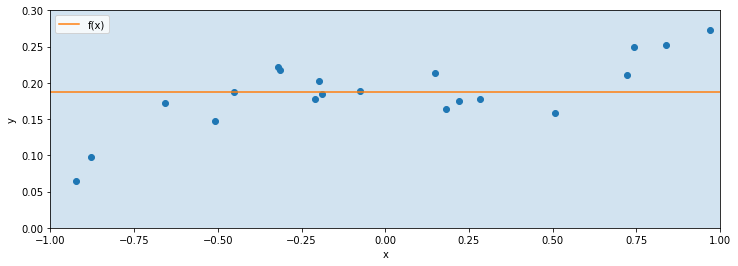

In [24]:
forrest = xgboost1d(xs, ys, 1, 0)
pred_test = pred1d(forrest, xtest)
plot_region1d(forrest[0])

# Depth 1

- One split
- Two leafs 
- Two constant regions

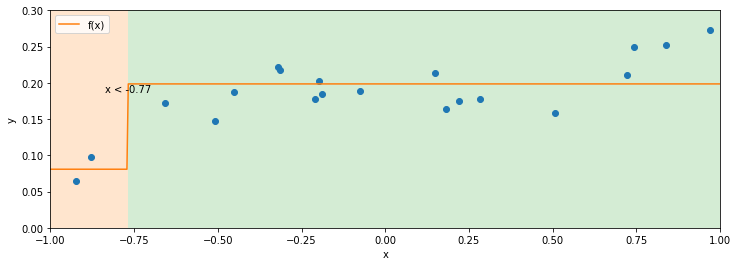

In [25]:
forrest = xgboost1d(xs, ys, 1, 1)
pred_test = pred1d(forrest, xtest)
plot_region1d(forrest[0])

# Depth 2

- Three splits
- Four leaves - four regions

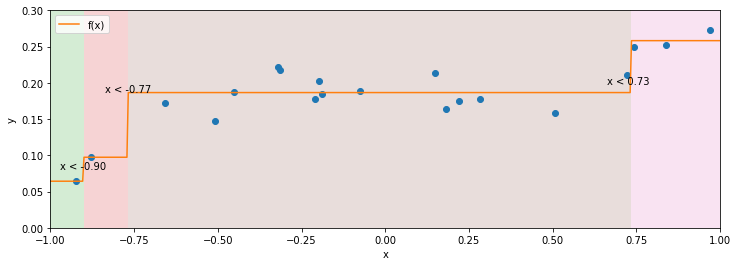

In [26]:
forrest = xgboost1d(xs, ys, 1, 2)
pred_test = pred1d(forrest, xtest)
plot_region1d(forrest[0])

# Depth 8

- Etc.
- Unique mappings:
    - point to value (because function)
    - point to leaf (remember for later)
- So given a function represented by a tree $t(x)$, we can decompose it into two parts:
    - Map points to one of the $L$ leaves: $q : \mathbb{R} \mapsto \{0, \ldots, L-1\}$
    - A vector $w\in \mathbb{R}^L$ of $L$ weights: the constant values at the leaves
    - Then, $t(x) = w_{q(x)}$

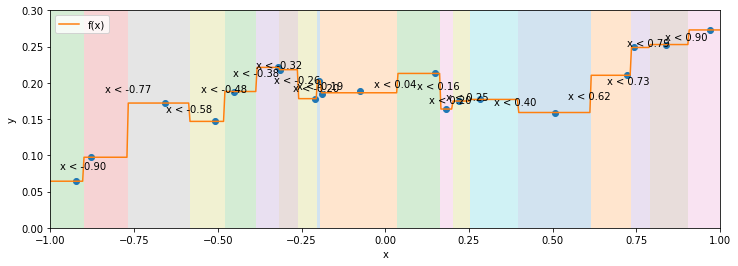

In [27]:
forrest = xgboost1d(xs, ys, 1, 8)
pred_test = pred1d(forrest, xtest)
plot_region1d(forrest[0])

# Challenges Learning Decision Trees

- Tree is discrete: no gradient-based training
    - optimization over discrete objects often result in combinatorial explosion
- A single tree is highly non-linear: 
    - small changes in the data might dramatically affect the structure
- Techniques:
    - Discrete optimization: use greedy heuristic
    - High-variance of single tree: use an ensemble of many trees
- Simplest tree ensemble method: bagging/random forrest (coming to `cuml` soon)
    - Performs often worse than XGBoost

# Learning Algorithm: XGBoost

- Summary of the excellent official intro: [https://xgboost.readthedocs.io/en/latest/tutorials/model.html](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
    - Purpose here: get the gist and notation to understand how to translate to code
    - A few crucial details omitted (like regularization)
- Boosting: stage-wise (greedy) additive model of $T$ trees defines the function $f_\theta$ as
$$ f_{\theta}^{(T)}(x) = \sum_{k=1}^T t_{\theta}^{(k)}(x)$$
    - or recursively, which reflects, how we will learn the ensemble
$$ f_{\theta}^{(T)}(x) =  f_{\theta}^{(T-1)}(x) + t_{\theta}^{(T)}(x) $$
- The algorithm progresses sequentially, performing $T$ rounds
- Implication: $t^{(k)}$ should not be trained on the original labels $y$ but the _residual_ $y - f^{(k)}$ (in regression)
    - the $k$-th tree tries to "fix" the errors, the model at the previous round made
    - But: _without_ revisiting their parameters (greedy)
- Need two ingredients, that are related 
    - Criterion to optimize to set the function value
    - Scoring structures to decide where to make a split



# XGBoost: Summary

- Similar to GLMs, the trees in XGBoost are functions into the Reals, hence we can use the same objective functions/likelihood terms (but we will see again, that the details can be abstracted away as well)
    - regression: $l_{sq}(y, f_\theta(x)) = \frac{1}{2} (y - f_\theta(x))^2$
    - classification: $l_\sigma(y, f_\theta(x)) = \log \sigma(f_\theta(x)) + (1 - y) \log (1 - \sigma(f_\theta(x)))$
- The optimization problem at each stage $k$ is to add a tree such that the error is reduced, i.e.
$$ E(t_{\theta}^{(k)}) = \sum_{i=1}^N l(y_i, f_\theta(x_i)^{(k-1)} + t_\theta^{(k)}(x_i))$$

# XGBoost: Summary

- Instead of considering $E$ directly, the first approximation the XGBoost method introduces, is to approximate this error with it's _second order Taylor expansion_, i.e. with a quadratic function (which is of course exact for the squared loss)
- We treat the existing model as the point and the new tree as the perturbation, with $g_i, h_i$ the first and second derivatives of the loss

\begin{aligned}
 E(t_{\theta}^{(k)}) &= \sum_{i=1}^N l(y_i, f_\theta(x_i)^{(k-1)} + t_\theta^{(k)}(x_i))   \\
 \sum_{i=1}^N l(y_i, f + t)&\approx \sum_{i=1}^N l(y_i, f) + g_i t + \frac{1}{2} h_i  t^2  \doteq \sum_{i=1}^N   g_i t + \frac{1}{2} h_i  t^2  \\
\end{aligned}

- Just like GLMs! Again, from the loss, we only need derivatives to drive the algorithm!
    - $g = \frac{\partial}{\partial f} l(y, f), g_i = g(y_i, f(x_i))$
    - $h = \frac{\partial^2}{\partial f^2} l(y, f), h_i = g(y_i, f(x_i))$
- Of course, for $l_{sq}(y, f)$ this is exact and $g = (f-y), h = 1$

# XGBoost: Summary

- Remember our view on trees:
    - A vector $w\in \mathbb{R}^L$ of $L$ weights: the constant values at the leaves
    - Then, $t(x) = w_{q(x)}$
- Given a tree, i.e. $w$ and $q$, we can find all training samples in a leaf $n$
    - We can find the set $\mathcal{L}_n = \{i \mid q(x_i) = n\}$
    - Note: $t(x_i) = w_n$ for all $x_i$ s.t. $i \in \mathcal{L}_n$
- Now for any given tree, with $L$ the number of leaves , we can re-write $E(t) = \sum_{i=1}^N   g_i t + \frac{1}{2} h_i  t^2 $ in terms of $w$ and $\mathcal{L}$:

\begin{aligned}
E(t)  &= \sum_{i=1}^N   g_i t + \frac{1}{2} h_i  t^2  = \sum_{n=1}^L (\sum_{i \in \mathcal{L}_n}   g_i) w_n + \frac{1}{2} (\sum_{i \in \mathcal{L}_n} h_i) w_n^2   \\
 &= \sum_{n=1}^L G_n w_n + \frac{1}{2} H_n w_n^2  
\end{aligned}   

- Nicely decomposes over the parameters of the tree 

# XGBoost: Summary

- Find the minimizer $w^*$ of $E(t) = \sum_{n=1}^L G_n w_n + \frac{1}{2} H_n w_n^2$ analytically
    - Assumption: the loss is twice differentiable, (strongly) convex: $h > 0$

\begin{aligned}
w_n^* = - \frac{G_n}{H_n} \qquad
E(w^* \mid q) = -\frac{1}{2}\sum_{n=1}^L  \frac{G_n^2}{H_n}
\end{aligned}

- We still assume that we are given some particular tree _structure_, i.e. the point to leaf mapping $q$
- Now: contribution of leaf $n$ to the loss:  $\propto \frac{G_n^2}{H_n} = \frac{(\sum_{i \in \mathcal{L}_n} g_i)^2}{
\sum_{i \in \mathcal{L}_n } h_i
}$ - is it worth breaking up the points in leaf $n$, i.e.  $\mathcal{L}_n$ into two? What's the "gain"?
- Gain of new split into $n_{left}, n_{right}$: "contrib. $\mathcal{L}_{n_{left}}$ + contrib. $\mathcal{L}_{n_{right}}$ - contrib. $\mathcal{L}_n$"
$$ \text{Gain} = \frac{G_{n_{left}}^2}{H_{n_{left}}} + \frac{G_{n_{right}}^2}{H_{n_{right}}} - \frac{G_n^2}{H_n} $$

# XGBoost: Greedy Tree Building Algorithm

- Given a set of $N$ training points:
    - for each feature:
        - sort the points by feature value
        - for each possible $N-1$ split positions find the split with the best gain 
    - partition the points according to the split
    - recurse left of the split and right of the split

# Tree Building Algorithm in 1D

- Does not take into account searching over features

```python
def gain(g,h,it):
    Gl, Gr = sum(g[:it+1]), sum(g[it+1:])
    Hl, Hr = sum(h[:it+1]), sum(h[it+1:])
    return  Gl**2 / Hl # contrib. left
          + Gr**2 / Hr # contrib. right
          - (Gl+Gr)**2 / (Hl+Hr) # cost of removing current leaf

def build1d(x, g, h, d, max_depth):
    n = Node()
    n.value = -sum(g) / sum(h) # determine current function value E, i.e. the constant w
    # check stopping criterion:
    if d == max_depth or len(x) == 1: 
        return n
    # evaluate splits and maximize gain
    max_score, split = max([(gain(g,h,it) , it) for it in range(len(x) - 1)])
    n.split = 0.5*(x[split] + x[split+1]) # split in the middle
    # divide points and recurse on the split
    n.left = build1d(x[:split+1], g[:split+1], h[:split+1], d+1, max_depth)
    n.right = build1d(x[split+1:], g[split+1:], h[split+1:], d+1, max_depth)
    return n
```

# Toy XGBoost Algorithm  for Regression

```python
def xgboost1d(xs, ys, rounds, depth): #single input feature is already sorted 
    forrest = []                      #we're growing a forrest
    yprev = np.zeros_like(ys)         #initial predictions are constant 0
    h = np.ones(len(ys))              #for squared loss, h is constant 1
    for r in range(rounds):
        g = yprev - ys                #update g, the residual
        root = build1d(xs, g, h, 0, depth) #tree
        yprev += np.array([eval1d(root, x_) for x_ in xs]) #update the prediction of the whole model
        forrest.append(root)          #add to the forrest
    return forrest

def pred1d(forrest, x):
    pred = np.zeros_like(x.flatten())
    for tree in forrest:              #evaluate contribution from each tree and sum up
        pred += np.array([eval1d(tree, x_) for x_ in x])
    return pred
```

# XGBoost API Example

```python
import xgboost as xgb

dtrain = xgb.DMatrix(x, y)
dtest = xgb.DMatrix(xtest)
param = {'max_depth':3,                       #depth of the tree
         'eta':1,                             #magic: learning rate
         'silent':0,
         'objective':'reg:squarederror',      #regression: loss function
         'reg_lambda':0}                      #l2 regularization parameter

num_round = 2                                 #number of rounds: trees in the forrest

bst = xgb.train(param, dtrain, num_round)
xgb_pred = bst.predict(dtest)
```

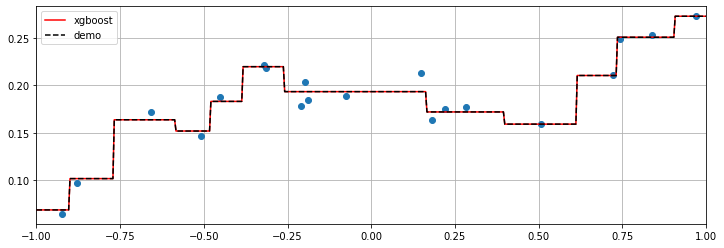

In [28]:
import xgboost as xgb

dtrain = xgb.DMatrix(x, y)
dtest = xgb.DMatrix(xtest)
param = {'max_depth':3,
         'eta':1,
         'silent':0,
         'objective':'reg:squarederror',
         'reg_lambda':0}
num_round = 2
bst = xgb.train(param, dtrain, num_round)
xgb_pred = bst.predict(dtest)

sidx = np.argsort(x.flatten())
xs,ys = x[sidx,0], y[sidx,0]
forrest = xgboost1d(xs, ys, 2, 3)
demo_pred = pred1d(forrest, xtest)

plt.figure(figsize=(12,4))
plt.plot(x,y, 'o')
plt.plot(xtest,xgb_pred, 'r-', ms=1, label='xgboost')
plt.plot(xtest,demo_pred, 'k--', ms=1, label = 'demo')
plt.xlim([-1,1])
plt.legend()
plt.grid(True)

# Summary

- Discussed trees as a function class
- Saw the same techniques as in GLMs to model data types
- Worked through the XGBoost derivation
    - Greedy approximations
    - Taylor approximation
    - Loss-based splitting criterion (structure score)
- Looked at a toy implementation to clarify the concepts
- Important, but missing: regularization of weights and tree size
    - Subtract penalties from gain of a split: increase in complexity might cancel gain

# RAPIDS CUML - Some already Distributed
<br>
<center>
 <img src="cuml_algo.png" style="width: 800px;"/>  